In [1]:
# Imports

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import glob

import scipy.signal
import holidays

from interpret.blackbox import LimeTabular
from interpret import show

import shap

import xgboost as xgb

from joblib import dump, load

from pandas.tseries.offsets import MonthEnd

import seaborn as sb

import IPython

In [35]:
# Get the data from the UK dataset

data = {}

temp_data = pd.read_csv('UK/train/pv_train_set4.csv')
temp_data.index = pd.to_datetime(temp_data['datetime'])
temp_data.drop('datetime', axis=1, inplace=True)
temp_data = temp_data.resample('15T').pad()

data['uk'] = temp_data

In [36]:
# Aux Functions for adding 2D time information

import datetime

def days_2d(df):
    '''
    Adds 2D time information for single days
    df: dataframe to add the information
    '''
    # Map the index into seconds
    timestamp_s = pd.to_datetime(df.index.values).map(datetime.datetime.timestamp)
    
    # Since we're calculating the cos and sin values from seconds, it's 60 seconds into 60 min into 24 hours per day
    day_calc = 24*60*60
    
    # Calculate the values
    dayx = np.cos((2*np.pi/day_calc) * timestamp_s)
    dayy = np.sin((2*np.pi/day_calc) * timestamp_s)
    
    return dayx, dayy
    

def years_2d(df):
    '''
    Adds 2D time representation throught a year
    df: dataframe to add the information
    '''
    # Add Year Information

    day_year = df.index.dayofyear
    year_constant = 365.2524

    yearx = np.cos((2*np.pi/year_constant) * day_year)
    yeary = np.sin((2*np.pi/year_constant) * day_year)
    
    return yearx, yeary

In [37]:
# Add the 2D time information to the data

for upac in data.keys():
    dayx, dayy = days_2d(data[upac])
    yearx, yeary = years_2d(data[upac])
    
    data[upac]['Day X'] = dayx
    data[upac]['Day Y'] = dayy
    
    data[upac]['Year X'] = yearx
    data[upac]['Year Y'] = yeary

In [52]:
# Split the data for training, validation and testing

data_train = {}
data_val = {}
data_test = {}

for upac in data.keys():
    data_train[upac] = data[upac]['2018']
    data_val[upac] = data[upac]['2019-01':'2019-03']
    data_test[upac] = data[upac]['2019-04':]

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


In [53]:
# Aux Function for filtering data

def filter_by_points(df, frequency='D', num_points=1440, return_dictionary=False):
    
    df_dropped = df.dropna()
    grouper = df_dropped.groupby(pd.Grouper(freq=frequency))
    
    output = 0
    if return_dictionary:
        new_dict = {}
        for i in grouper:
            if (len(i[1]) != num_points):
                pass
            else:
                new_dict[i[0]] = pd.DataFrame(i[1])
        output = new_dict
    else:
        new_df = pd.DataFrame({})
        for i in grouper:
            if (len(i[1]) != num_points):
                pass
            else:
                new_df = new_df.append(pd.DataFrame(i[1]))
        output = new_df
            
    return output

In [54]:
# Filter the data by number of points that should be present in a single day

filtered_train = {}
filtered_val = {}
filtered_test = {}

for upac in data_train.keys():
    filtered_train[upac] = filter_by_points(data_train[upac], frequency='D', num_points=1440/15)
    filtered_val[upac] = filter_by_points(data_val[upac], frequency='D', num_points=1440/15)
    filtered_test[upac] = filter_by_points(data_test[upac], frequency='D', num_points=1440/15)

In [55]:
# Select columns to use

USED_COLUMNS = ['irradiance_Wm-2', 
                'pv_power_mw', 
                'panel_temp_C', 
                'Day Y', 'Day X',
                'Year Y', 'Year X']

In [56]:
# Data Normalization
# We don't want to normalize PV so we can capture diferences more easily

# Feature range
# PV - greater than 0
# Irradiance - normalize between 0 and 1
# Panel Temp - Unchanged
# Day X, Y and Year X and Y - already between -1 and 1

MAX_GHI = 1117.440000 # max value on the training set

normalized_train = {}
normalized_val = {}
normalized_test = {}

for upac in filtered_train.keys():
    normalized_train[upac] = filtered_train[upac][USED_COLUMNS].copy(deep=True)
    normalized_val[upac] = filtered_val[upac][USED_COLUMNS].copy(deep=True)
    normalized_test[upac] = filtered_test[upac][USED_COLUMNS].copy(deep=True)
    
    normalized_train[upac]['irradiance_Wm-2'] = normalized_train[upac]['irradiance_Wm-2'] / MAX_GHI
    normalized_val[upac]['irradiance_Wm-2'] = normalized_val[upac]['irradiance_Wm-2'] / MAX_GHI
    normalized_test[upac]['irradiance_Wm-2'] = normalized_test[upac]['irradiance_Wm-2'] / MAX_GHI

In [57]:
# Split the data into X and y

X_train = {}
y_train = {}

X_val = {}
y_val = {}

X_test = {}
y_test = {}

for upac in normalized_train.keys():
    trainx = normalized_train[upac].drop('pv_power_mw', axis=1)
    trainy = normalized_train[upac]['pv_power_mw']
    valx = normalized_val[upac].drop('pv_power_mw', axis=1)
    valy = normalized_val[upac]['pv_power_mw']
    testx = normalized_test[upac].drop('pv_power_mw', axis=1)
    testy = normalized_test[upac]['pv_power_mw']
    
    X_train[upac] = trainx
    X_val[upac] = valx
    X_test[upac] = testx
    
    y_train[upac] = trainy
    y_val[upac] = valy
    y_test[upac] = testy

In [58]:
# Get the XGBoost model

xgb_model = load('models/xgboost/uk_all/Model 01.joblib')

xgb_yhat = pd.read_csv('results/xgboost/uk_all/test/Model 01.csv', index_col='datetime')
xgb_yhat.index = pd.to_datetime(xgb_yhat.index)

In [59]:
# Test set SHAP values

# Get the SHAP values
tree_obj = shap.TreeExplainer(xgb_model)

temp_shap = tree_obj.shap_values(X_test['uk'], check_additivity=False)

temp_shap_df = pd.DataFrame(temp_shap,
                            columns=X_test['uk'].columns,
                            index=X_test['uk'].index)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [60]:
# Overall SHAP values (baseline)

np.abs(temp_shap_df).describe().loc['mean'].sort_values(ascending=False)

irradiance_Wm-2    0.811482
Year X             0.017496
Day Y              0.015161
panel_temp_C       0.011562
Year Y             0.008093
Day X              0.007409
Name: mean, dtype: float64

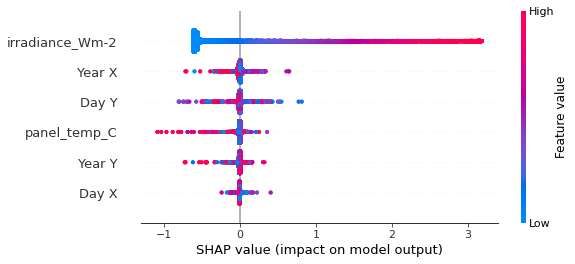

In [61]:
# Test set SHAP plot

plt.figure(figsize=(8, 6))
shap.summary_plot(temp_shap, X_test['uk'])

In [62]:
# Add season information to dataframes

def extract_season(df):
    
    date = df.index.month*100 + df.index.day
    df['season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                           labels=['winter','spring','summer','autumn','winter '])
                    #.str.strip()
                   )
    df['season'] = df['season'].str.replace(' ', '')
    df['season'] = df['season'].astype('category')
    
    df['season_int'] = df['season'].cat.codes
    
    return

df_model = temp_shap_df.copy(deep=True)
extract_season(df_model)
df_model.drop('season_int', inplace=True, axis=1)

df_testx = X_test['uk'].copy(deep=True)
extract_season(df_testx)
df_testx.drop('season_int', inplace=True, axis=1)

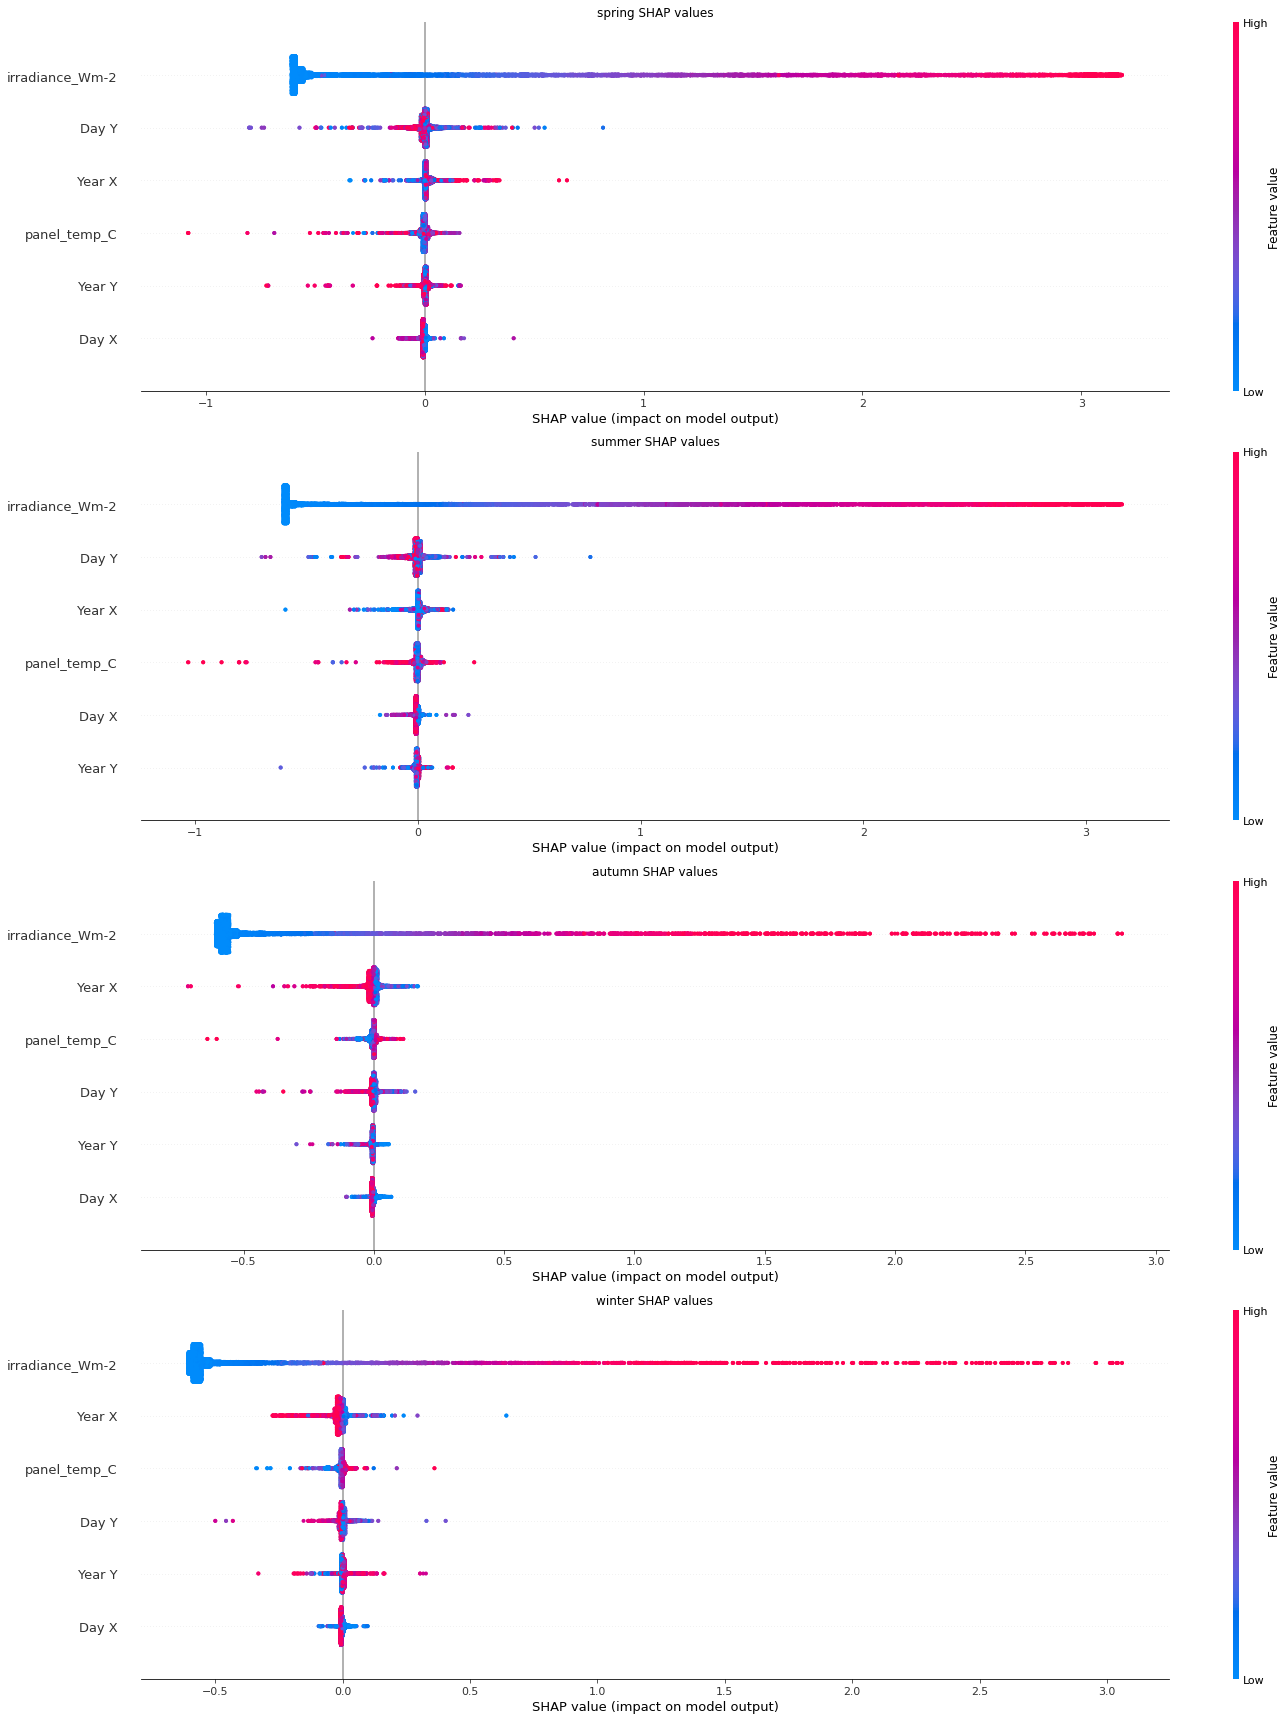

In [63]:
# Model Season analysis

fig = plt.figure(figsize=(20, 24))
current_axs = 0

for season in df_model['season'].unique():
    plt.subplot(4, 1, current_axs+1)
    
    season_shap = df_model.loc[df_model['season'] == season].drop(['season'], axis=1).values
    season_data = df_testx.loc[df_testx['season'] == season].drop(['season'], axis=1)
    
    temp_axs = shap.summary_plot(season_shap, season_data,
                                 plot_size=None, show=False)
    plt.title('{} SHAP values'.format(season))
    current_axs += 1
    
plt.tight_layout()

In [64]:
# Model 10 SHAP values for each season

season_shap = {}
for season in df_model['season'].unique():
    season_shap[season] = np.abs(df_model.loc[df_model['season'] == season].drop('season', axis=1)).describe().loc['mean']
    
season_shap = pd.DataFrame(season_shap)
season_shap = season_shap.reindex(columns=['autumn', 'winter', 'spring', 'summer'])
season_shap = season_shap.transpose()

season_shap = season_shap.reindex(columns=['irradiance_Wm-2', 'Day Y', 'Day X', 'Year Y', 'Year X'])

In [65]:
# Show the SHAP values by season

season_shap

,irradiance_Wm-2,Day Y,Day X,Year Y,Year X
autumn,0.595101,0.009065,0.006660,0.008093,0.017603
winter,0.591904,0.009005,0.006377,0.006628,0.020317
spring,0.962184,0.018324,0.007775,0.009135,0.015914
summer,0.943108,0.020625,0.008363,0.007676,0.017510


In [66]:
# Check the top k SHAP scores

season_shap_th = pd.DataFrame({})

for i in season_shap.index:
    temp_vals = pd.DataFrame(season_shap.loc[i] > season_shap.loc[i]['irradiance_Wm-2'] * 0.5)
    temp_vals.columns = [i]
    temp_vals = temp_vals.transpose()
    
    season_shap_th = pd.concat([season_shap_th, temp_vals])
    
season_shap_th

,irradiance_Wm-2,Day Y,Day X,Year Y,Year X
autumn,True,False,False,False,False
winter,True,False,False,False,False
spring,True,False,False,False,False
summer,True,False,False,False,False
